# Imports

In [2]:
import pandas as pd 
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
from funcoes_module import rms, pk_pk, kurtosis, crest_factor, skewness, shape_factor, std_value, min_value, max_value, mean_value
from funcoes_module import extract_info_from_filename, extract_and_format_dataframe, format_time, features_extract, features_timeframe,format_dataframe_basona ,extract_datasets_and_process_features,read_1file_datasets , combine_features_datasets 
from funcoes_module import plot_df,plot_df_features, compare_df_plots #,plot_health_non_health_features
from descricoes_SE import descricao_falha

In [4]:
redundant_ft_drop_list = ['gearbox_vibration_x.rms','gearbox_vibration_z.kurtosis','gearbox_vibration_z.rms','gearbox_vibration_x.crest_factor','gearbox_vibration_x.min','gearbox_vibration_x.pk_pk','Input Torque.mean']

## Funções Formatação

In [5]:
#### #### Funções Formatação #### ####
def normalize_data(dataframe):
    scaler = MinMaxScaler() 
    # Selecting numerical columns in the DataFrame
    numerical_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns
    #normalized_df =dataframe.copy()
    # Fitting the scaler and transforming the data
    df2 = dataframe.copy()
    df2[numerical_cols] = scaler.fit_transform(df2[numerical_cols])
    return df2

def fault_to_binary(dataframe):
    df_features = dataframe.copy()
    if not ((df_features['Fault'] == 0) | (df_features['Fault'] == 1)).all(): #condição para não dar ruim se aplicar 2x a função
        df_features['Fault'] = df_features['Fault'].apply(lambda x: 0 if x == 'health' else 1)
    #df_features['Fault'].value_counts()
    return df_features

def top_features_list(df_features, num_features):
    # Select numeric types from the DataFrame
    df_features_num = df_features.select_dtypes(include=['float64', 'int64'])
    
    # Compute the absolute correlation with 'Fault'
    top_features = abs(df_features_num.corr()['Fault'])
    
    # Drop the 'Fault' column from the series to avoid self-correlation
    top_features = top_features.drop('Fault', axis=0)
    
    # Get the 'num_features' largest values
    largest_features = top_features.nlargest(num_features)
    
    # Return the index of the largest features as a list
    features_chosen = largest_features.index.tolist()
    return features_chosen

def filter_top_features_df(df_features,top_features):    
    filtered_columns = top_features + ['Fault','Torque']#,'Degree']
    df_features = df_features[filtered_columns]
    return df_features

def format_dataframe_features(df_features_org,number_of_features):

    normalized_dataframe = normalize_data(df_features_org)
    binary_fault_dataframe = fault_to_binary(normalized_dataframe)

    top_ft_list = top_features_list(binary_fault_dataframe,number_of_features)

    df_top_features = filter_top_features_df(binary_fault_dataframe,top_ft_list)
    return df_top_features,binary_fault_dataframe

# Início
- df_treino_ciclo1
- df_treino_ciclo2
- df_teste_ciclo1
- df_teste_ciclo2
  
Importando dataset treino

In [6]:
# importando e criando basone treino
df_features_org = combine_features_datasets("todos","inicial",0.1)
########df_features_org = df_features_org[df_features_org['Torque']=='20Nm']

#df_features_org2 = df_features_org.drop(columns=redundant_ft_drop_list) #dropando features redundantes
normalized_dataframe = normalize_data(df_features_org)

df_treino_ciclo2 = normalized_dataframe
df_treino_ciclo1 = fault_to_binary(normalized_dataframe) #transformando variável alvo em binário (encoding)


# Importando e criando basona teste
df_features_org_t = combine_features_datasets("todos","final",0.1) #treino,teste,todos ; inicial,final ; timeframe
#######df_features_org_t = df_features_org_t[df_features_org_t['Torque']=='20Nm']
#df_features_org_t2 = df_features_org_t.drop(columns=redundant_ft_drop_list)
normalized_dataframe_t = normalize_data(df_features_org_t)

df_teste_ciclo1 = fault_to_binary(normalized_dataframe_t)
df_teste_ciclo2 = normalized_dataframe_t


Columns [col] not found in [filename]
number of files geral = 23
combined files geral: ['gear_pitting_H_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_H_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_L_torque_circulation_2000rpm_20Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_10Nm.csv', 'gear_pitting_M_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_H_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_L_torque_circulation_2000rpm_20Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_10Nm.csv', 'gear_wear_M_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_H_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_L_torque_circulation_2000rpm_20Nm.csv', 'teeth_break_M_torque_circulation_2000rpm_10Nm.csv', 'teeth_break_M_to

# Organizando as variáveis 
## Organizando as variáveisCiclo1 
### Dividir Conjunto em treino e teste
- df_treino_ciclo1
- df_teste_ciclo1
  
importante usar o meu encoder próprio pq ele classifica do jeito q eu quero 1 = tudo menos health, 0 = health

Separando entre treino e teste

In [7]:
categorias_list = ['Categoria','Degree','Rotação']

dataset_treino_c1 = df_treino_ciclo1.drop(columns=categorias_list)   # 60%
dataset_teste_c1 = df_teste_ciclo1.drop(columns=categorias_list) #40%

Separando X e y

In [8]:
#treino
X_train_c1 = dataset_treino_c1.drop(columns='Fault')#.iloc[:,-2:] filtrar n features
y_train_c1 = dataset_treino_c1.pop('Fault')

#teste
X_test_c1 = dataset_teste_c1.drop(columns='Fault')
y_test_c1 = dataset_teste_c1.pop('Fault')


In [9]:
print(f' Treino: x ={X_train_c1.shape} ; y = {y_train_c1.shape}')
print(f' Teste: x ={X_test_c1.shape} ; y = {y_test_c1.shape}')

 Treino: x =(2160, 41) ; y = (2160,)
 Teste: x =(2133, 41) ; y = (2133,)


Tratando a coluna categórica 'Torque' com label encoding

In [10]:
from sklearn.preprocessing import LabelEncoder
# Assuming 'Torque' column is in both X_train, X_val, and X_test
le = LabelEncoder()

# Fit and transform on the training data
X_train_c1['Torque'] = le.fit_transform(X_train_c1['Torque'])
X_test_c1['Torque'] = le.transform(X_test_c1['Torque'])

### Criando variáveis de treino e teste

In [11]:
categorias_list = ['Categoria','Degree','Rotação']

dataset_treino_c2 = df_treino_ciclo2.drop(columns=categorias_list)   # 60%
dataset_teste_c2 = df_teste_ciclo2.drop(columns=categorias_list) #40%

In [12]:
#treino
X_train_c2 = dataset_treino_c2.drop(columns='Fault')#.iloc[:,-2:] filtrar n features
y_train_c2x = dataset_treino_c2.pop('Fault')

#teste
X_test_c2 = dataset_teste_c2.drop(columns='Fault')
y_test_c2x = dataset_teste_c2.pop('Fault')

In [13]:
print(f' Treino: x ={X_train_c2.shape} ; y = {y_train_c2x.shape}')
print(f' Teste: x ={X_test_c2.shape} ; y = {y_test_c2x.shape}')

 Treino: x =(2160, 41) ; y = (2160,)
 Teste: x =(2133, 41) ; y = (2133,)


Label Encoders
- torque
- target (y)

In [14]:
from sklearn.preprocessing import LabelEncoder
# Assuming 'Torque' column is in both X_train, X_val, and X_test
le = LabelEncoder()

# Fit and transform on the training data
X_train_c2['Torque'] = le.fit_transform(X_train_c2['Torque'])
X_test_c2['Torque'] = le.transform(X_test_c2['Torque'])

aplicando encoder na target variable (opcional aparentemente)

In [15]:

# # Initialize label encoder for target variable
le_y = LabelEncoder()

# # Fit and transform the target variable
y_train_c2 = le_y.fit_transform(y_train_c2x.values)
y_test_c2 = le_y.transform(y_test_c2x.values)

### Resultado:
Criação das variáveis:
- X_train_c1
- X_train_c2
- y_train_c1
- y_train_c2
-
- X_teste_c1
- X_teste_c2
- y_teste_c1
- y_teste_c2

# Execução dos modelos 

In [16]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Testando númerode features

n= 1 score: 0.4032679738562091
n= 2 score: 0.42777777777777776
n= 3 score: 0.4145280790011577
n= 4 score: 0.5231757590974401
n= 5 score: 0.8323814822760146
n= 6 score: 0.8593185475067678
n= 7 score: 0.8654691883839267
n= 8 score: 0.8557481947914963
n= 9 score: 0.8729161285202722
n= 10 score: 0.9051320077887315
n= 11 score: 0.8851498787858975
n= 12 score: 0.8993020187746996
n= 13 score: 0.8960799149823924
n= 14 score: 0.895309058632268
n= 15 score: 0.8809691821395065
n= 16 score: 0.8839770484098675
n= 17 score: 0.8789685973969018
n= 18 score: 0.8963274444424156
n= 19 score: 0.9096368044253871
n= 20 score: 0.9166793598035529
n= 21 score: 0.9044792882474386
n= 22 score: 0.918530387302119
n= 23 score: 0.9245856364702751
n= 24 score: 0.919264006843825
n= 25 score: 0.9249272780433652
n= 26 score: 0.9361187175987934
n= 27 score: 0.919640871926236
n= 28 score: 0.9304829583362887
n= 29 score: 0.9440959496296157
n= 30 score: 0.9446284780570303
n= 31 score: 0.9401542907512547
n= 32 score: 0.93911

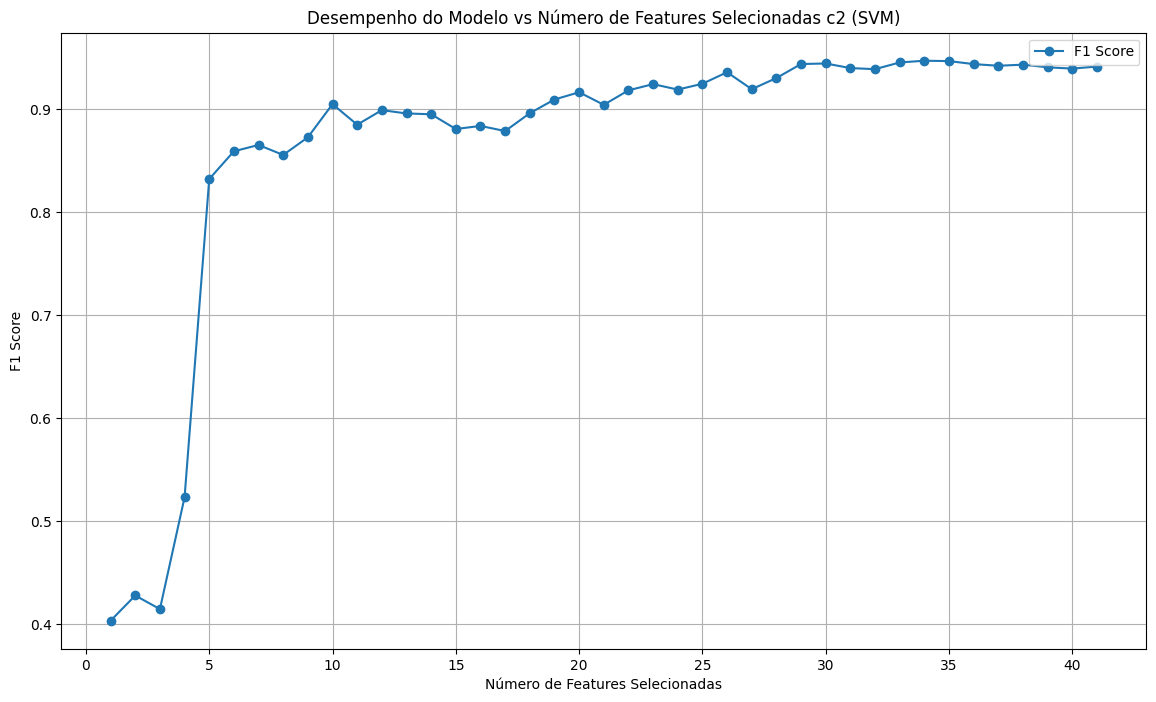

In [17]:
estimator = DecisionTreeClassifier()

# Listas para armazenar as métricas
num_features = list(range(1, X_train_c2.shape[1] + 1))
f1_scores = []
# Loop através de diferentes números de features
start_time_c2_ft = time.time()

for n in num_features:
    rfe = RFE(estimator=estimator, n_features_to_select=n)
    rfe = rfe.fit(X_train_c2, y_train_c2)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_c2_rfe = rfe.transform(X_train_c2)
    X_test_c2_rfe = rfe.transform(X_test_c2)
    
    # Inicializar e treinar o modelo SVM
    svm_model = SVC()
    svm_model.fit(X_train_c2_rfe, y_train_c2)    
    # Fazer previsões no conjunto de teste
    y_pred_svm_test_c2 = svm_model.predict(X_test_c2_rfe)
    
    # Calcular o F1 score
    f1 = f1_score(y_test_c2, y_pred_svm_test_c2, average='macro')
    
    # Armazenar a métrica
    f1_scores.append(f1)
    print(f'n= {n} score: {f1}')

end_time_c2_ft = time.time()
# Plotar o F1 score em relação ao número de features
plt.figure(figsize=(14, 8))
plt.plot(num_features, f1_scores, label='F1 Score', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('F1 Score')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas c2 (SVM)')
plt.legend()
plt.grid(True)
plt.show()

executar algoritmo com melhor feature (24)
e plotar matriz de confusão

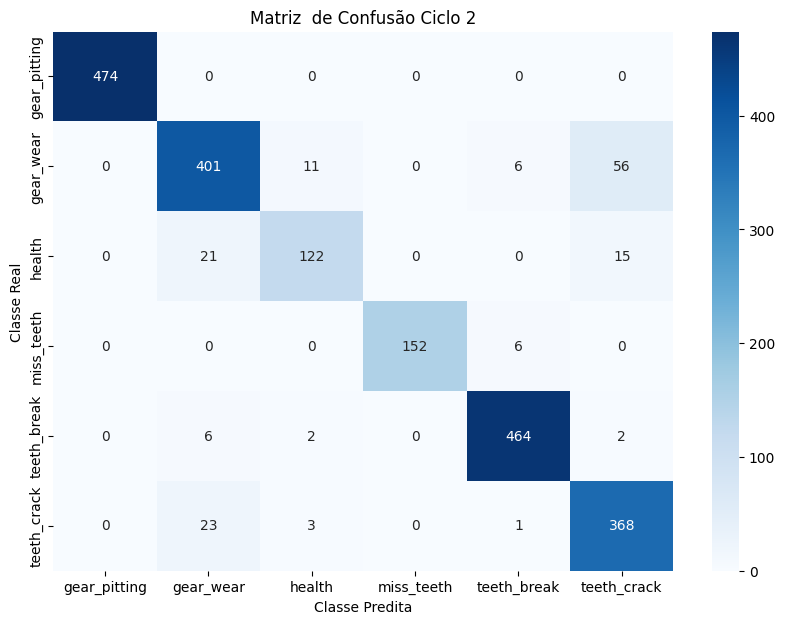

f1-score = 0.9213657032353643


In [18]:
# executar algoritmo com melhor número
start_time_c2_svm = time.time()

rfe = RFE(estimator=estimator, n_features_to_select=40)
rfe = rfe.fit(X_train_c2, y_train_c2)

# Transformar os conjuntos de treino e teste para selecionar as principais features
X_train_c2_rfe = rfe.transform(X_train_c2)
X_test_c2_rfe = rfe.transform(X_test_c2)

# Inicializar e treinar o modelo SVM
svm_model = SVC()
svm_model.fit(X_train_c2_rfe, y_train_c2)    
# Fazer previsões no conjunto de teste
y_pred_svm_test_c2 = svm_model.predict(X_test_c2_rfe)


end_time_c2_svm = time.time()
# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_c2, y_pred_svm_test_c2)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le_y.classes_, yticklabels=le_y.classes_)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz  de Confusão Ciclo 2')
plt.show()

f1_svm_test_c2 = f1_score(y_test_c2, y_pred_svm_test_c2, average='macro')

print(f'f1-score = {f1_svm_test_c2}')

In [19]:
# Resultados Ciclo 2
accuracy_svm_test_c2 = accuracy_score(y_test_c2, y_pred_svm_test_c2)
recall_svm_test_c2 = recall_score(y_test_c2, y_pred_svm_test_c2, average='macro')
f1_svm_test_c2 = f1_score(y_test_c2, y_pred_svm_test_c2, average='macro')

print(f'accuracy = {accuracy_svm_test_c2}')
print(f'recall = {recall_svm_test_c2}')
print(f'f1-score = {f1_svm_test_c2}')

accuracy = 0.9287388654477262
recall = 0.9151195499296764
f1-score = 0.9213657032353643


# Código Unificado 1 modelo - SVM Ciclo 2

n= 1 score: 0.4032679738562091
n= 2 score: 0.40094091816295857
n= 3 score: 0.5272143739800775
n= 4 score: 0.7504765495677352
n= 5 score: 0.6995909114448825
n= 6 score: 0.7367065180738793
n= 7 score: 0.7430311554143904
n= 8 score: 0.8569943462727972
n= 9 score: 0.8610305832893991
n= 10 score: 0.875528820755212
n= 11 score: 0.8599926336923936
n= 12 score: 0.8835179677409716
n= 13 score: 0.8757582721017974
n= 14 score: 0.8921096934766662
n= 15 score: 0.8892078669606737
n= 16 score: 0.8956939258371511
n= 17 score: 0.8942887006311769
n= 18 score: 0.907089530354333
n= 19 score: 0.9321491174219774
n= 20 score: 0.9166793598035529
n= 21 score: 0.9047776224889136
n= 22 score: 0.9036570921605347
n= 23 score: 0.9274234228545287
n= 24 score: 0.9096848779509726
n= 25 score: 0.9191853526748334
n= 26 score: 0.9380819783092481
n= 27 score: 0.9246346303399551
n= 28 score: 0.9139408227396099
n= 29 score: 0.9415352567723084
n= 30 score: 0.9134494281253834
n= 31 score: 0.9378455955803466
n= 32 score: 0.940

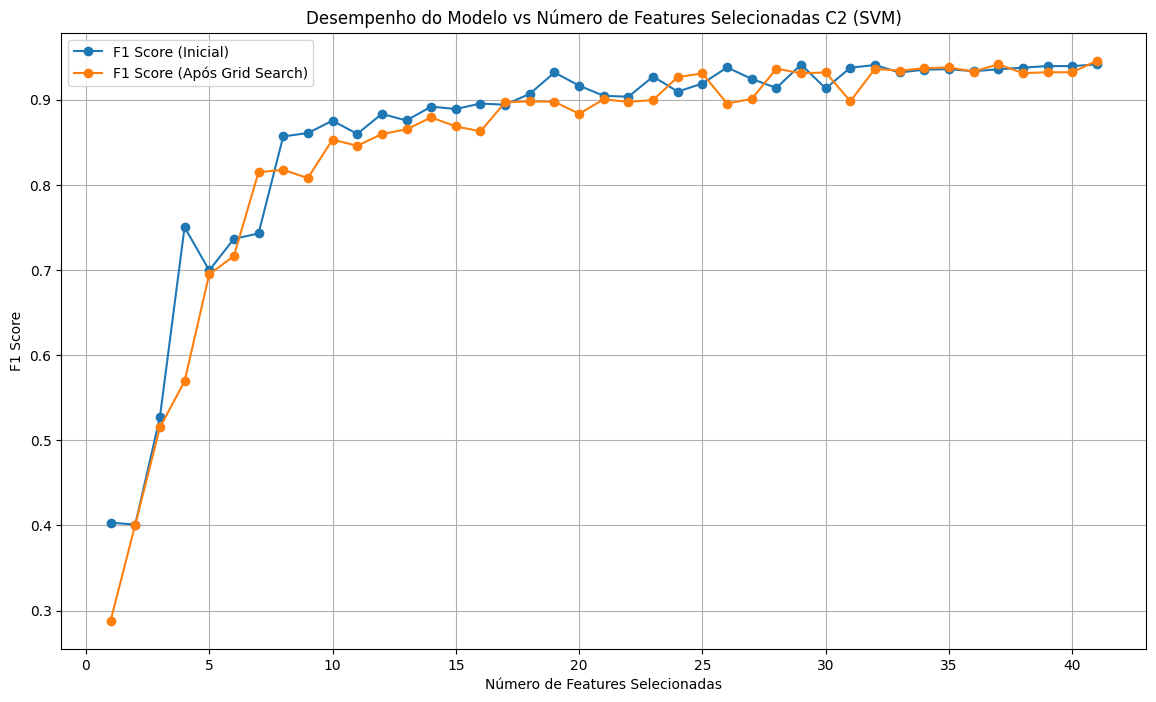

In [23]:
# CICLO 2 SVM

import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definir o modelo SVM padrão
svm_model = SVC()

# Listas para armazenar as métricas
num_features = list(range(1, X_train_c2.shape[1] + 1))
f1_scores_initial = []

# Loop através de diferentes números de features (antes do grid search)
start_time_feature_loop_initial = time.time()
for n in num_features:
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n)
    rfe = rfe.fit(X_train_c2, y_train_c2)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_c2_rfe = rfe.transform(X_train_c2)
    X_test_c2_rfe = rfe.transform(X_test_c2)
    
    # Inicializar e treinar o modelo SVM
    svm_model.fit(X_train_c2_rfe, y_train_c2)    
    
    # Fazer previsões no conjunto de teste
    y_pred_svm_test_c2 = svm_model.predict(X_test_c2_rfe)
    
    # Calcular o F1 score
    f1 = f1_score(y_test_c2, y_pred_svm_test_c2, average='macro')
    
    # Armazenar a métrica
    f1_scores_initial.append(f1)
    print(f'n= {n} score: {f1}')
end_time_feature_loop_initial = time.time()
total_time_feature_loop_initial = end_time_feature_loop_initial - start_time_feature_loop_initial
print(f'Tempo total do loop de features (inicial): {total_time_feature_loop_initial} segundos')

# Identificar a melhor feature antes do grid search
best_num_features_initial = num_features[np.argmax(f1_scores_initial)]
print(f'Melhor número de features (inicial): {best_num_features_initial} com F1 score: {max(f1_scores_initial)}')

# Avaliar o modelo com 10 features (antes do grid search)
rfe_10_initial = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
rfe_10_initial = rfe_10_initial.fit(X_train_c2, y_train_c2)
X_train_c2_rfe_10_initial = rfe_10_initial.transform(X_train_c2)
X_test_c2_rfe_10_initial = rfe_10_initial.transform(X_test_c2)
svm_model.fit(X_train_c2_rfe_10_initial, y_train_c2)
y_pred_svm_test_c2_10_initial = svm_model.predict(X_test_c2_rfe_10_initial)
f1_score_10_initial = f1_score(y_test_c2, y_pred_svm_test_c2_10_initial, average='macro')
print(f'F1 score para 10 features (inicial): {f1_score_10_initial}')

# Avaliar o modelo com o melhor número de features (antes do grid search)
rfe_best_initial = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=best_num_features_initial)
rfe_best_initial = rfe_best_initial.fit(X_train_c2, y_train_c2)
X_train_c2_rfe_best_initial = rfe_best_initial.transform(X_train_c2)
X_test_c2_rfe_best_initial = rfe_best_initial.transform(X_test_c2)
svm_model.fit(X_train_c2_rfe_best_initial, y_train_c2)
y_pred_svm_test_c2_best_initial = svm_model.predict(X_test_c2_rfe_best_initial)
f1_score_best_initial = f1_score(y_test_c2, y_pred_svm_test_c2_best_initial, average='macro')
print(f'F1 score para o melhor número de features ({best_num_features_initial}) (inicial): {f1_score_best_initial}')

# Início da contagem do tempo da busca em grade
start_time_grid_search = time.time()

# Definir o grid de parâmetros para a busca em grade
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

# Inicializar e realizar a busca em grade
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_c2, y_train_c2)

# Melhores parâmetros da busca em grade
best_params = grid_search.best_params_
print(f'Melhores parâmetros encontrados: {best_params}')

# Armazenar os melhores hiperparâmetros
best_C = best_params['C']
best_gamma = best_params['gamma']
best_kernel = best_params['kernel']

# Fim da contagem do tempo da busca em grade
end_time_grid_search = time.time()
total_time_grid_search = end_time_grid_search - start_time_grid_search
print(f'Tempo total da busca em grade: {total_time_grid_search} segundos')

# Definir o modelo SVM com os melhores hiperparâmetros
best_svm_model = SVC(C=best_C, gamma=best_gamma, kernel=best_kernel)

# Listas para armazenar as métricas
f1_scores = []

# Início da contagem do tempo do loop de features
start_time_feature_loop = time.time()

# Loop através de diferentes números de features (depois do grid search)
for n in num_features:
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n)
    rfe = rfe.fit(X_train_c2, y_train_c2)
    
    # Transformar os conjuntos de treino e teste para selecionar as principais features
    X_train_c2_rfe = rfe.transform(X_train_c2)
    X_test_c2_rfe = rfe.transform(X_test_c2)
    
    # Inicializar e treinar o modelo SVM com os melhores hiperparâmetros
    best_svm_model.fit(X_train_c2_rfe, y_train_c2)    
    
    # Fazer previsões no conjunto de teste
    y_pred_svm_test_c2 = best_svm_model.predict(X_test_c2_rfe)
    
    # Calcular o F1 score
    f1 = f1_score(y_test_c2, y_pred_svm_test_c2, average='macro')
    
    # Armazenar a métrica
    f1_scores.append(f1)
    print(f'n= {n} score: {f1}')

# Fim da contagem do tempo do loop de features
end_time_feature_loop = time.time()
total_time_feature_loop = end_time_feature_loop - start_time_feature_loop
print(f'Tempo total do loop de features: {total_time_feature_loop} segundos')

# Identificar a melhor feature após o grid search
best_num_features = num_features[np.argmax(f1_scores)]
print(f'Melhor número de features (após grid search): {best_num_features} com F1 score: {max(f1_scores)}')

# Avaliar o modelo com 10 features (após o grid search)
rfe_10 = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10)
rfe_10 = rfe_10.fit(X_train_c2, y_train_c2)
X_train_c2_rfe_10 = rfe_10.transform(X_train_c2)
X_test_c2_rfe_10 = rfe_10.transform(X_test_c2)
best_svm_model.fit(X_train_c2_rfe_10, y_train_c2)
y_pred_svm_test_c2_10 = best_svm_model.predict(X_test_c2_rfe_10)
f1_score_10 = f1_score(y_test_c2, y_pred_svm_test_c2_10, average='macro')
print(f'F1 score para 10 features (após grid search): {f1_score_10}')

# Avaliar o modelo com o melhor número de features (após o grid search)
rfe_best = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=best_num_features)
rfe_best = rfe_best.fit(X_train_c2, y_train_c2)
X_train_c2_rfe_best = rfe_best.transform(X_train_c2)
X_test_c2_rfe_best = rfe_best.transform(X_test_c2)
best_svm_model.fit(X_train_c2_rfe_best, y_train_c2)
y_pred_svm_test_c2_best = best_svm_model.predict(X_test_c2_rfe_best)
f1_score_best = f1_score(y_test_c2, y_pred_svm_test_c2_best, average='macro')
print(f'F1 score para o melhor número de features ({best_num_features}) (após grid search): {f1_score_best}')

# Plotar o F1 score em relação ao número de features (após grid search)
plt.figure(figsize=(14, 8))
plt.plot(num_features, f1_scores_initial, label='F1 Score (Inicial)', marker='o')
plt.plot(num_features, f1_scores, label='F1 Score (Após Grid Search)', marker='o')
plt.xlabel('Número de Features Selecionadas')
plt.ylabel('F1 Score')
plt.title('Desempenho do Modelo vs Número de Features Selecionadas C2 (SVM)')
plt.legend()
plt.grid(True)
plt.show()


# Código Unificado Resultado todos modelos Ciclo 1

In [29]:
import time
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Supondo que essas variáveis estejam definidas no seu ambiente:
# X_train_c1, y_train_c1, X_test_c1, y_test_c1

# Modelos a serem analisados
models = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Parâmetros para grid search
param_grids = {
    'SVM': {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30]}
}

# Números de features a serem analisados inicialmente
features_to_analyze = [1, 5, 10, 15, 20, 30, 40]

# Iterar sobre cada modelo
for model_name, model in models.items():
    print(f'\nModelo: {model_name}\n')

    # Listas para armazenar os F1 scores
    f1_scores_initial = []
    f1_scores_grid_search = []

    # Loop através dos números de features especificados (antes do grid search)
    for n in features_to_analyze:
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n)
        rfe = rfe.fit(X_train_c1, y_train_c1)
        
        # Transformar os conjuntos de treino e teste para selecionar as principais features
        X_train_c1_rfe = rfe.transform(X_train_c1)
        X_test_c1_rfe = rfe.transform(X_test_c1)
        
        # Inicializar e treinar o modelo
        model.fit(X_train_c1_rfe, y_train_c1)    
        
        # Fazer previsões no conjunto de teste
        y_pred_test_c1 = model.predict(X_test_c1_rfe)
        
        # Calcular o F1 score
        f1 = f1_score(y_test_c1, y_pred_test_c1, average='macro')
        
        # Armazenar a métrica
        f1_scores_initial.append(f1)

    # Encontrar o melhor número de features antes do grid search
    best_num_features_initial = features_to_analyze[np.argmax(f1_scores_initial)]
    print(f'Melhor número de features (inicial): {best_num_features_initial} com F1 score: {max(f1_scores_initial)}')

    # Adicionar o melhor número de features à lista
    if best_num_features_initial not in features_to_analyze:
        features_to_analyze.append(best_num_features_initial)
        features_to_analyze = sorted(features_to_analyze)

    # Início da contagem do tempo da busca em grade
    start_time_grid_search = time.time()

    # Definir o grid de parâmetros para a busca em grade
    param_grid = param_grids[model_name]

    # Inicializar e realizar a busca em grade
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train_c1, y_train_c1)

    # Melhores parâmetros da busca em grade
    best_params = grid_search.best_params_
    print(f'Melhores parâmetros encontrados: {best_params}')

    # Armazenar os melhores hiperparâmetros
    best_model = grid_search.best_estimator_

    # Fim da contagem do tempo da busca em grade
    end_time_grid_search = time.time()
    total_time_grid_search = end_time_grid_search - start_time_grid_search
    print(f'Tempo total da busca em grade: {total_time_grid_search} segundos')

    # Loop através dos números de features especificados (depois do grid search)
    for n in features_to_analyze:
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n)
        rfe = rfe.fit(X_train_c1, y_train_c1)
        
        # Transformar os conjuntos de treino e teste para selecionar as principais features
        X_train_c1_rfe = rfe.transform(X_train_c1)
        X_test_c1_rfe = rfe.transform(X_test_c1)
        
        # Inicializar e treinar o modelo com os melhores hiperparâmetros
        best_model.fit(X_train_c1_rfe, y_train_c1)    
        
        # Fazer previsões no conjunto de teste
        y_pred_test_c1 = best_model.predict(X_test_c1_rfe)
        
        # Calcular o F1 score
        f1 = f1_score(y_test_c1, y_pred_test_c1, average='macro')
        
        # Armazenar a métrica
        f1_scores_grid_search.append(f1)

    # Criar o DataFrame de resultados
    results_df = pd.DataFrame({
        'N. Features': features_to_analyze,
        'F1 Scores s/ hiperparâmetro': f1_scores_initial,
        'F1 Scores c/ hiperparâmetro': f1_scores_grid_search
    })

    # Exibir o DataFrame de resultados
    print(results_df)



Modelo: SVM

Melhor número de features (inicial): 40 com F1 score: 0.8702259363641359
Melhores parâmetros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Tempo total da busca em grade: 3.895563840866089 segundos
   N. Features  F1 Scores s/ hiperparâmetro  F1 Scores c/ hiperparâmetro
0            1                     0.480769                     0.480769
1            5                     0.480769                     0.480769
2           10                     0.480769                     0.480769
3           15                     0.524014                     0.646475
4           20                     0.707769                     0.878765
5           30                     0.843508                     0.922169
6           40                     0.870226                     0.984300

Modelo: KNN

Melhor número de features (inicial): 1 com F1 score: 0.9713161875945537
Melhores parâmetros encontrados: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Tempo t

# Código Unificado Resultado todos modelos Ciclo 2

In [30]:
# CICLO 2 MODELOS

import time
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Supondo que essas variáveis estejam definidas no seu ambiente:
# X_train_c2, y_train_c2, X_test_c2, y_test_c2

# Modelos a serem analisados
models = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Parâmetros para grid search
param_grids = {
    'SVM': {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30]}
}

# Números de features a serem analisados inicialmente
features_to_analyze = [1, 5, 10, 15, 20, 30, 40]

# Iterar sobre cada modelo
for model_name, model in models.items():
    print(f'\nModelo: {model_name}\n')

    # Listas para armazenar os F1 scores
    f1_scores_initial = []
    f1_scores_grid_search = []

    # Loop através dos números de features especificados (antes do grid search)
    for n in features_to_analyze:
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n)
        rfe = rfe.fit(X_train_c2, y_train_c2)
        
        # Transformar os conjuntos de treino e teste para selecionar as principais features
        X_train_c2_rfe = rfe.transform(X_train_c2)
        X_test_c2_rfe = rfe.transform(X_test_c2)
        
        # Inicializar e treinar o modelo
        model.fit(X_train_c2_rfe, y_train_c2)    
        
        # Fazer previsões no conjunto de teste
        y_pred_test_c2 = model.predict(X_test_c2_rfe)
        
        # Calcular o F1 score
        f1 = f1_score(y_test_c2, y_pred_test_c2, average='macro')
        
        # Armazenar a métrica
        f1_scores_initial.append(f1)

    # Encontrar o melhor número de features antes do grid search
    best_num_features_initial = features_to_analyze[np.argmax(f1_scores_initial)]
    print(f'Melhor número de features (inicial): {best_num_features_initial} com F1 score: {max(f1_scores_initial)}')

    # Adicionar o melhor número de features à lista
    if best_num_features_initial not in features_to_analyze:
        features_to_analyze.append(best_num_features_initial)
        features_to_analyze = sorted(features_to_analyze)

    # Início da contagem do tempo da busca em grade
    start_time_grid_search = time.time()

    # Definir o grid de parâmetros para a busca em grade
    param_grid = param_grids[model_name]

    # Inicializar e realizar a busca em grade
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train_c2, y_train_c2)

    # Melhores parâmetros da busca em grade
    best_params = grid_search.best_params_
    print(f'Melhores parâmetros encontrados: {best_params}')

    # Armazenar os melhores hiperparâmetros
    best_model = grid_search.best_estimator_

    # Fim da contagem do tempo da busca em grade
    end_time_grid_search = time.time()
    total_time_grid_search = end_time_grid_search - start_time_grid_search
    print(f'Tempo total da busca em grade: {total_time_grid_search} segundos')

    # Loop através dos números de features especificados (depois do grid search)
    for n in features_to_analyze:
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n)
        rfe = rfe.fit(X_train_c2, y_train_c2)
        
        # Transformar os conjuntos de treino e teste para selecionar as principais features
        X_train_c2_rfe = rfe.transform(X_train_c2)
        X_test_c2_rfe = rfe.transform(X_test_c2)
        
        # Inicializar e treinar o modelo com os melhores hiperparâmetros
        best_model.fit(X_train_c2_rfe, y_train_c2)    
        
        # Fazer previsões no conjunto de teste
        y_pred_test_c2 = best_model.predict(X_test_c2_rfe)
        
        # Calcular o F1 score
        f1 = f1_score(y_test_c2, y_pred_test_c2, average='macro')
        
        # Armazenar a métrica
        f1_scores_grid_search.append(f1)

    # Criar o DataFrame de resultados
    results_df = pd.DataFrame({
        'N. Features': features_to_analyze,
        'F1 Scores s/ hiperparâmetro': f1_scores_initial,
        'F1 Scores c/ hiperparâmetro': f1_scores_grid_search
    })

    # Exibir o DataFrame de resultados
    print(results_df)



Modelo: SVM

Melhor número de features (inicial): 30 com F1 score: 0.9470458619582205
Melhores parâmetros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Tempo total da busca em grade: 12.474632978439331 segundos
   N. Features  F1 Scores s/ hiperparâmetro  F1 Scores c/ hiperparâmetro
0            1                     0.403268                     0.287990
1            5                     0.699591                     0.694488
2           10                     0.869643                     0.843038
3           15                     0.891323                     0.889848
4           20                     0.911923                     0.884139
5           30                     0.947046                     0.930873
6           40                     0.939660                     0.943792

Modelo: KNN

Melhor número de features (inicial): 30 com F1 score: 0.9365273068279537
Melhores parâmetros encontrados: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Temp

Plot Matriz de Confusão todos modelos Ciclo 2


Modelo: SVM

Melhor número de features (inicial): 40 com F1 score: 0.9396604090146555
Melhores parâmetros encontrados: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Tempo total da busca em grade: 15.29831314086914 segundos
   N. Features  F1 Scores s/ hiperparâmetro  F1 Scores c/ hiperparâmetro
0            1                     0.403268                     0.287990
1            5                     0.832738                     0.694488
2           10                     0.849021                     0.845251
3           15                     0.881711                     0.862298
4           20                     0.934786                     0.881770
5           30                     0.939265                     0.934557
6           40                     0.939660                     0.932425
Melhor número de features (após grid search): 30 com F1 score: 0.9345572958751752


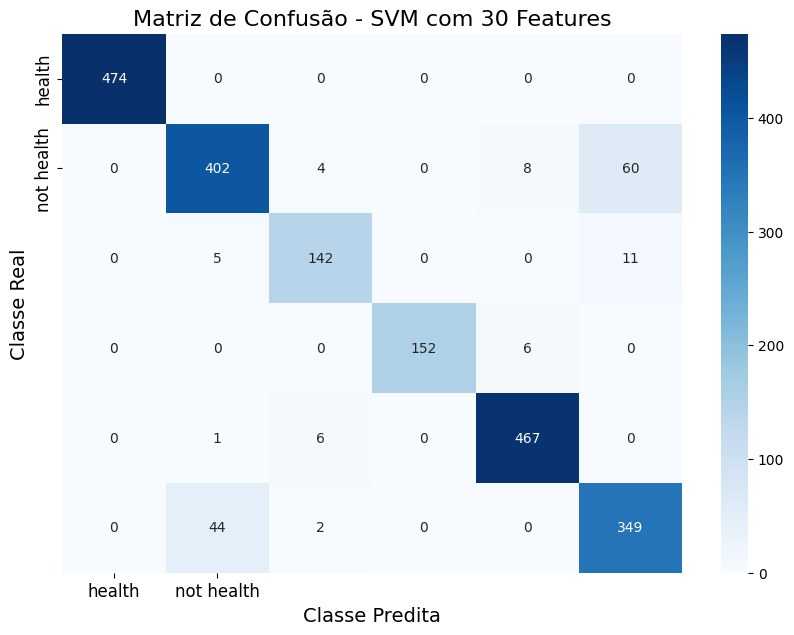


Modelo: KNN

Melhor número de features (inicial): 30 com F1 score: 0.936909682871005
Melhores parâmetros encontrados: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Tempo total da busca em grade: 5.106651067733765 segundos
   N. Features  F1 Scores s/ hiperparâmetro  F1 Scores c/ hiperparâmetro
0            1                     0.698489                     0.686700
1            5                     0.867872                     0.894767
2           10                     0.920368                     0.960542
3           15                     0.930206                     0.949710
4           20                     0.924997                     0.941947
5           30                     0.936910                     0.959550
6           40                     0.931729                     0.947870
Melhor número de features (após grid search): 10 com F1 score: 0.9605415825830429


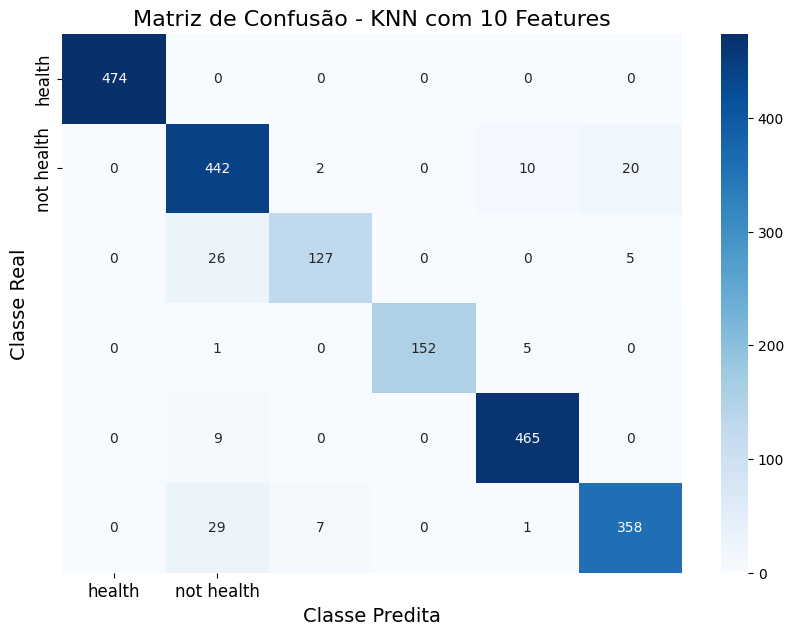


Modelo: Decision Tree

Melhor número de features (inicial): 10 com F1 score: 0.9116616370245129
Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}
Tempo total da busca em grade: 6.435024261474609 segundos
   N. Features  F1 Scores s/ hiperparâmetro  F1 Scores c/ hiperparâmetro
0            1                     0.650660                     0.643250
1            5                     0.875133                     0.799888
2           10                     0.911662                     0.870766
3           15                     0.850101                     0.860750
4           20                     0.867026                     0.872788
5           30                     0.877072                     0.883204
6           40                     0.876403                     0.880090
Melhor número de features (após grid search): 30 com F1 score: 0.8832040156494624


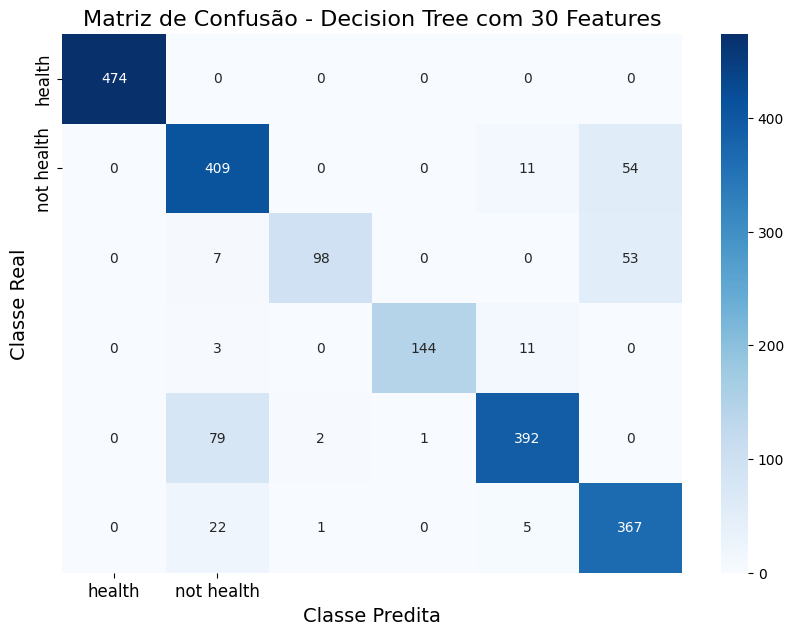


Modelo: Random Forest

Melhor número de features (inicial): 30 com F1 score: 0.9734431181256751
Melhores parâmetros encontrados: {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 150}
Tempo total da busca em grade: 82.70224809646606 segundos
   N. Features  F1 Scores s/ hiperparâmetro  F1 Scores c/ hiperparâmetro
0            1                     0.359367                     0.695240
1            5                     0.899105                     0.888277
2           10                     0.954046                     0.925821
3           15                     0.939763                     0.942065
4           20                     0.935709                     0.936168
5           30                     0.973443                     0.966816
6           40                     0.967663                     0.966792
Melhor número de features (após grid search): 30 com F1 score: 0.9668155216944339


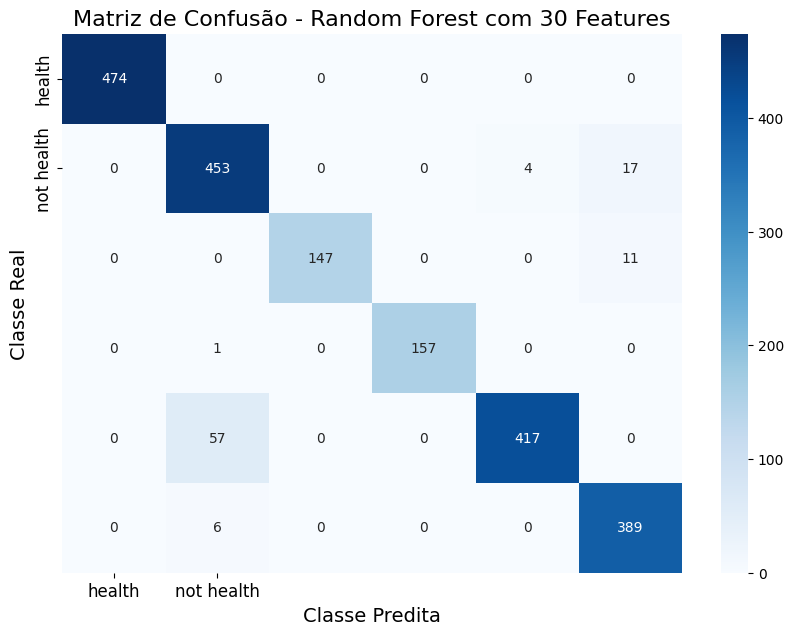

In [31]:
# CICLO 2 MODELOS

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Supondo que essas variáveis estejam definidas no seu ambiente:
# X_train_c2, y_train_c2, X_test_c2, y_test_c2

# Modelos a serem analisados
models = {
    'SVM': SVC(),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

# Parâmetros para grid search
param_grids = {
    'SVM': {'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'], 'kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
    'KNN': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'Decision Tree': {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10]},
    'Random Forest': {'n_estimators': [50, 100, 150], 'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30]}
}

# Números de features a serem analisados inicialmente
features_to_analyze = [1, 5, 10, 15, 20, 30, 40]

# Iterar sobre cada modelo
for model_name, model in models.items():
    print(f'\nModelo: {model_name}\n')

    # Listas para armazenar os F1 scores
    f1_scores_initial = []
    f1_scores_grid_search = []

    # Loop através dos números de features especificados (antes do grid search)
    for n in features_to_analyze:
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n)
        rfe = rfe.fit(X_train_c2, y_train_c2)
        
        # Transformar os conjuntos de treino e teste para selecionar as principais features
        X_train_c2_rfe = rfe.transform(X_train_c2)
        X_test_c2_rfe = rfe.transform(X_test_c2)
        
        # Inicializar e treinar o modelo
        model.fit(X_train_c2_rfe, y_train_c2)    
        
        # Fazer previsões no conjunto de teste
        y_pred_test_c2 = model.predict(X_test_c2_rfe)
        
        # Calcular o F1 score
        f1 = f1_score(y_test_c2, y_pred_test_c2, average='macro')
        
        # Armazenar a métrica
        f1_scores_initial.append(f1)

    # Encontrar o melhor número de features antes do grid search
    best_num_features_initial = features_to_analyze[np.argmax(f1_scores_initial)]
    print(f'Melhor número de features (inicial): {best_num_features_initial} com F1 score: {max(f1_scores_initial)}')

    # Adicionar o melhor número de features à lista
    if best_num_features_initial not in features_to_analyze:
        features_to_analyze.append(best_num_features_initial)
        features_to_analyze = sorted(features_to_analyze)

    # Início da contagem do tempo da busca em grade
    start_time_grid_search = time.time()

    # Definir o grid de parâmetros para a busca em grade
    param_grid = param_grids[model_name]

    # Inicializar e realizar a busca em grade
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
    grid_search.fit(X_train_c2, y_train_c2)

    # Melhores parâmetros da busca em grade
    best_params = grid_search.best_params_
    print(f'Melhores parâmetros encontrados: {best_params}')

    # Armazenar os melhores hiperparâmetros
    best_model = grid_search.best_estimator_

    # Fim da contagem do tempo da busca em grade
    end_time_grid_search = time.time()
    total_time_grid_search = end_time_grid_search - start_time_grid_search
    print(f'Tempo total da busca em grade: {total_time_grid_search} segundos')

    # Loop através dos números de features especificados (depois do grid search)
    for n in features_to_analyze:
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n)
        rfe = rfe.fit(X_train_c2, y_train_c2)
        
        # Transformar os conjuntos de treino e teste para selecionar as principais features
        X_train_c2_rfe = rfe.transform(X_train_c2)
        X_test_c2_rfe = rfe.transform(X_test_c2)
        
        # Inicializar e treinar o modelo com os melhores hiperparâmetros
        best_model.fit(X_train_c2_rfe, y_train_c2)    
        
        # Fazer previsões no conjunto de teste
        y_pred_test_c2 = best_model.predict(X_test_c2_rfe)
        
        # Calcular o F1 score
        f1 = f1_score(y_test_c2, y_pred_test_c2, average='macro')
        
        # Armazenar a métrica
        f1_scores_grid_search.append(f1)

    # Criar o DataFrame de resultados
    results_df = pd.DataFrame({
        'N. Features': features_to_analyze,
        'F1 Scores s/ hiperparâmetro': f1_scores_initial,
        'F1 Scores c/ hiperparâmetro': f1_scores_grid_search
    })

    # Exibir o DataFrame de resultados
    print(results_df)
    
    # Encontrar o melhor número de features após o grid search
    best_num_features = features_to_analyze[np.argmax(f1_scores_grid_search)]
    print(f'Melhor número de features (após grid search): {best_num_features} com F1 score: {max(f1_scores_grid_search)}')
    
    # Treinar novamente com o melhor número de features
    rfe_best = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=best_num_features)
    rfe_best = rfe_best.fit(X_train_c2, y_train_c2)
    X_train_c2_rfe_best = rfe_best.transform(X_train_c2)
    X_test_c2_rfe_best = rfe_best.transform(X_test_c2)
    
    # Inicializar e treinar o modelo com os melhores hiperparâmetros
    best_model.fit(X_train_c2_rfe_best, y_train_c2)    
    
    # Fazer previsões no conjunto de teste
    y_pred_test_c2_best = best_model.predict(X_test_c2_rfe_best)
    
    # Plotar a matriz de confusão
    conf_matrix = confusion_matrix(y_test_c2, y_pred_test_c2_best)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['health', 'not health'], yticklabels=['health', 'not health'])
    plt.xlabel('Classe Predita', fontsize=14)
    plt.ylabel('Classe Real', fontsize=14)
    plt.title(f'Matriz de Confusão - {model_name} com {best_num_features} Features', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
